# Introduction:

In this project, we set out to find which neighborhood, in the Pittsburgh area, is the best to live in. We started by creating our metric "Overall Quality of Life" which is formed by our three submetrics. These submetrics are crime rate, education quality, and local income. By scoring each of the neighborhoods in these categories and finding which neighborhood has the best score overall, we will decide which is the best to live in!

# **The Metric:**

#### **Overall Quality of Life**

This is our overall metric which is comprised of a highest sum of the three submetrics. We chose these three submetrics as they are very easy to consolidate and produce a good general idea of which neighborhood is the best.

#### **Crime Rates**

By looking at all of the arrests in the Pittsburgh area from August 2016 to present we will be able to see where arrestable offenses happen most frequently. This will then allow us to create a score where the neighborhood with the least crime receives the highest rating.

#### **Education Quality**

More in depth description here

#### **Local Income**

More in depth description here

# Submetric: Crime
---
## Arrest Data (2016-Present):
By mapping the Arrests around Pittsburgh to a neighborhood, we can figure out which town is the safest.

* Once I have all of the arrests mapped to a neighborhood in Pittsburgh I can create a score to indicate which neighborhoods have the least crime.

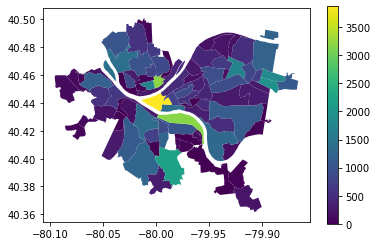

In [27]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

crimeData = pd.read_csv("Crime-Rating/Crime-Data.csv")
neighborhoodBounds = gpd.read_file("https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/c5a93a8e-03d7-4eb3-91a8-c6b7db0fa261/download/pittsburghpaneighborhoods-.zip")
neighborhoodBounds["crimes"] = 0

crimeNeighborhoods = pd.DataFrame()

# Map the neighborhood names from the crimes dataset to the geo dataset (Fixes problem of Mt. Oliver Boro vs. Mt. Oliver neigborhood)
crimeNeighborhoods["lon"] = crimeData.groupby("INCIDENTNEIGHBORHOOD")["X"].mean()
crimeNeighborhoods["lat"] = crimeData.groupby("INCIDENTNEIGHBORHOOD")["Y"].mean()
crimeNeighborhoods["new"] = None

# Performs the mapping using the contains method based on the crimes longitude and latitude
for i, cN in crimeNeighborhoods.iterrows():
    for j, neighborhood in neighborhoodBounds.iterrows():
        if neighborhood["geometry"].contains(Point(cN["lon"], cN["lat"])):
            crimeNeighborhoods.loc[i, "new"] = neighborhood["hood"]
            break

# Adding up crimes in each neighborhood
countsByNeighborhood = crimeData["INCIDENTNEIGHBORHOOD"].value_counts()
for oldName, crimes in countsByNeighborhood.iteritems():
    newName = crimeNeighborhoods.loc[oldName, "new"]
    neighborhoodBounds.loc[neighborhoodBounds["hood"] == newName, "crimes"] += crimes

neighborhoodBounds.plot(column="crimes", legend=True)



# Mapping the Crime

Above we can see the matplotlib of the crimes in the city. There is a high concetration near The Point, however, there are also hotspots farther out.

In [24]:
neighborhoodBounds.loc[neighborhoodBounds["crimes"] > 0].sort_values("crimes").loc[:, ["hood", "crimes"]].head(20)

,hood,crimes
38,Central Northside,23
64,Ridgemont,35
37,New Homestead,39
50,Chartiers City,40
82,Swisshelm Park,40
28,East Carnegie,48
73,St. Clair,48
76,Summer Hill,67
7,Oakwood,79
23,Fairywood,112


# Data Inconsistancies

There were some neighborhoods that had zero arrests reported since 2016. This is not consistant with what can be found elsewhere online, so to keep things clean I simply removed the neighborhoods that had zero reported arrests. 

In [25]:
# Scores the neighborhoods

neighborhoodBounds["score"] = 1 - neighborhoodBounds["crimes"] / neighborhoodBounds["crimes"].max()

neighborhoodBounds.loc[neighborhoodBounds["crimes"] > 0].sort_values("crimes").loc[:, ["hood", "score"]].head(20)

,hood,score
38,Central Northside,0.994061
64,Ridgemont,0.990963
37,New Homestead,0.989930
50,Chartiers City,0.989672
82,Swisshelm Park,0.989672
28,East Carnegie,0.987607
73,St. Clair,0.987607
76,Summer Hill,0.982701
7,Oakwood,0.979602
23,Fairywood,0.971082


# Scores

Above are the top twenty neighborhoods based on lowest arrests reported above zero. This is only one metric though. It is important to look at the overall metric when deciding what is the best.

# Submetric: Income
---
## Aggregate Income per Household (2015):
This data has been adjusted for inflation.
* My plan is to find the total income of each neighborhood and divide it by the total population of each neighborhood to get an idea of how much income per person there is, which will be the main factor in determining this submetric.

In [8]:
import pandas as pd

inc = pd.read_csv("Income-Submetric/aggregate-household-income-in-the-past-12-months-in-2015-inflation-adjusted-dollars.csv")
pop = pd.read_csv("Income-Submetric/total-population.csv")

df = pd.merge(inc,pop,how='outer',on='Neighborhood')


df.head(10)


,Neighborhood,Id_x,Aggregate_Income,MOE_x,Id_y,Population,MOE_y
0,Allegheny Center,1,39947000,6437773,1,1411,196.000000
1,Allegheny West,2,23793300,22025939,2,343,96.000000
2,Allentown,3,38303700,7490207.043,3,2558,449.773276
3,Arlington,4,35349900,6140662.723,4,1852,348.188168
4,Arlington Heights,5,2389600,1162393,5,272,126.000000
5,Banksville,6,138084700,25839798.58,6,3858,581.107563
6,Bedford Dwellings,7,10529100,1666825,7,1349,180.000000
7,Beechview,8,193055900,20558893.78,8,8078,719.658252
8,Beltzhoover,9,28121300,6955896.138,9,1702,343.072879
9,Bloomfield,10,249898900,17631530.8,10,8669,491.348145


# Organizing the Data:

In [9]:
data = pd.DataFrame(columns=['Town','Aggregate_Income','Population'])

data['Town'] = inc['Neighborhood']
data['Aggregate_Income'] = inc['Aggregate_Income']
data['Population'] = pop['Population']


In [10]:
#this code is used for the scatterplot shown below
income = []
for value in data['Aggregate_Income']:
    try:
        currInc = int(value)
        income.append(currInc / 1000000)
    except:
        income.append(0)



data['Aggregate_Income_in_Millions'] = income

In [11]:
data.head(20)

,Town,Aggregate_Income,Population,Aggregate_Income_in_Millions
0,Allegheny Center,39947000,1411,39.9470
1,Allegheny West,23793300,343,23.7933
2,Allentown,38303700,2558,38.3037
3,Arlington,35349900,1852,35.3499
4,Arlington Heights,2389600,272,2.3896
5,Banksville,138084700,3858,138.0847
6,Bedford Dwellings,10529100,1349,10.5291
7,Beechview,193055900,8078,193.0559
8,Beltzhoover,28121300,1702,28.1213
9,Bloomfield,249898900,8669,249.8989


# Now we've got a DataFrame containing only the Town name, Population, and Aggregate Income in Millions

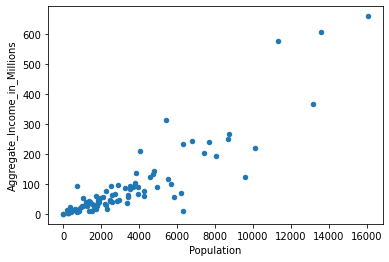

In [12]:
data.plot.scatter(x='Population',y='Aggregate_Income_in_Millions')

In [13]:
incdivpop = []
poplist = data['Population']
inclist = data['Aggregate_Income']
for p, i in zip(poplist,inclist):
    try:
        currIncy = int(i)
        currPopy = int(p)
        incdivpop.append(int(currIncy/currPopy))
    except:
        incdivpop.append(0)

data['Income_per_Person'] = incdivpop
data.head(5)


,Town,Aggregate_Income,Population,Aggregate_Income_in_Millions,Income_per_Person
0,Allegheny Center,39947000,1411,39.9470,28311
1,Allegheny West,23793300,343,23.7933,69368
2,Allentown,38303700,2558,38.3037,14974
3,Arlington,35349900,1852,35.3499,19087
4,Arlington Heights,2389600,272,2.3896,8785


# Note that Income per Person is rounded to the floor. 

In [14]:
data.drop({'Aggregate_Income','Population','Aggregate_Income_in_Millions'}, axis=1, inplace=True)


In [15]:
data.head(10)

,Town,Income_per_Person
0,Allegheny Center,28311
1,Allegheny West,69368
2,Allentown,14974
3,Arlington,19087
4,Arlington Heights,8785
5,Banksville,35791
6,Bedford Dwellings,7805
7,Beechview,23898
8,Beltzhoover,16522
9,Bloomfield,28826


In [16]:
#this is a list of the indexes of all the Towns protected by CPBP
indexlist = [18,80,17,47,86,65,72,73,8,15,78,4,19,26,70,88,76,77,58,63,64,28,39,40,41,42,87,5,13,7]
data = data.iloc[indexlist]

# Have to consolidate the repeats into a single Town


In [17]:
lville = data.loc[data['Town'].isin(['Central Lawrenceville', 'Lower Lawrenceville', 'Upper Lawrenceville'])]
average = lville['Income_per_Person'].mean()
lvillerow = pd.DataFrame({'Town': ['Lawrenceville'], 'Income_per_Person': [average]})
data = pd.concat([data,lvillerow], ignore_index=True)
data = data.drop(data[data['Town'].isin(['Central Lawrenceville', 'Lower Lawrenceville', 'Upper Lawrenceville'])].index).reset_index(drop=True)

In [18]:
#southside
sside = data.loc[data['Town'].isin(['South Side Flats', 'South Side Slopes'])]
average = sside['Income_per_Person'].mean()
ssiderow = pd.DataFrame({'Town': ['Southside'], 'Income_per_Person': [average]})
data = pd.concat([data,ssiderow], ignore_index=True)
data = data.drop(data[data['Town'].isin(['South Side Flats', 'South Side Slopes'])].index).reset_index(drop=True)



In [19]:
#oakland
oland = data.loc[data['Town'].isin(['South Oakland', 'North Oakland', 'West Oakland', 'Central Oakland'])]
average = oland['Income_per_Person'].mean()
olandrow = pd.DataFrame({'Town': ['Oakland'], 'Income_per_Person': [average]})
data = pd.concat([data,olandrow], ignore_index=True)
data = data.drop(data[data['Town'].isin(['South Oakland', 'North Oakland', 'West Oakland', 'Central Oakland'])].index).reset_index(drop=True)

In [20]:
#squirell hill
shill = data.loc[data['Town'].isin(['Squirrel Hill South', 'Squirrel Hill North'])]
average = shill['Income_per_Person'].mean()
shillrow = pd.DataFrame({'Town': ['Squirrel Hill'], 'Income_per_Person': [average]})
data = pd.concat([data,shillrow], ignore_index=True)
data = data.drop(data[data['Town'].isin(['Squirrel Hill South', 'Squirrel Hill North'])].index).reset_index(drop=True)

In [21]:
#point breeze
pbrez = data.loc[data['Town'].isin(['Point Breeze', 'Point Breeze North'])]
average = pbrez['Income_per_Person'].mean()
pbrezrow = pd.DataFrame({'Town': ['Point Breeze'], 'Income_per_Person': [average]})
data = data.drop(data[data['Town'].isin(['Point Breeze', 'Point Breeze North'])].index).reset_index(drop=True)
data = pd.concat([data,pbrezrow], ignore_index=True)



In [22]:
#homewood
hwood = data.loc[data['Town'].isin(['Homewood North', 'Homewood South', 'Homewood West'])]
average = hwood['Income_per_Person'].mean()
hwoodrow = pd.DataFrame({'Town': ['Home wood'], 'Income_per_Person': [average]})
data = data.drop(data[data['Town'].isin(['Homewood North', 'Homewood South', 'Homewood West'])].index).reset_index(drop=True)
data = pd.concat([data,hwoodrow], ignore_index=True)



In [23]:
data.head(21)

,Town,Income_per_Person
0,Central Northside,33317.000000
1,Strip District,122808.000000
2,Polish Hill,29217.000000
3,Beltzhoover,16522.000000
4,Carrick,21855.000000
5,St. Clair,14324.000000
6,Arlington Heights,8785.000000
7,East Carnegie,24500.000000
8,Northview Heights,5666.000000
9,East Liberty,20897.000000


# *Data on Downtown, and Uptown were not available

## Now lets assign a value from 0-1 to rank each Town based on their Income per Person

Average Income per Person among the Pittsburgh Towns:

In [40]:
totalavgJ = data['Income_per_Person'].mean()
print(totalavgJ)

29112.103174603177


Minimum Income per Person:

In [41]:
totalminJ = data['Income_per_Person'].min()
print(totalminJ)

5666.0


Maximum Income per Person:

In [42]:
totalmaxJ = data['Income_per_Person'].max()
print(totalmaxJ)

122808.0


In [43]:
listyJ = []
for value in data['Income_per_Person']:
    try:
        thisValJ = ((float(value)-totalminJ)/(totalmaxJ-totalminJ))
        listyJ.append(thisValJ)
    except:
        listyJ.append(0)

data['Normalized Income Score'] = listyJ
        

## In descending order, these scores are:

In [44]:
data.sort_values('Normalized Income Score', ascending=False)

,Town,Income_per_Person,Normalized Income Score
1,Strip District,122808.000000,1.000000
19,Point Breeze,46284.500000,0.346746
18,Squirrel Hill,46037.500000,0.344637
12,Banksville,35791.000000,0.257167
10,Highland Park,35595.000000,0.255493
0,Central Northside,33317.000000,0.236047
16,Southside,32012.500000,0.224911
2,Polish Hill,29217.000000,0.201047
13,Brookline,27883.000000,0.189659
15,Lawrenceville,26310.666667,0.176236


## As we can see, by Average Aggregate Household Income per Person, *Strip District*, *Point Breeze*, *Squirrel Hill*, *Banksville*, and *Highland Park* are some of the best places to live around Pittsburgh. 

---
But don't count out the other towns! Make sure to consider all three submetrics when deciding which town is the best. 

# **The Best Neighborhood:**

We can Update this tomorrow once we actually have an idea of which neighborhood is the best

# **Conclusion:**

Again, we will fix this tomorrow. Probably something like "We liked Oakland the best before but now that we have this data..."